# 4 Modeling - Investigating San Francisco Housing Prices Through Police Incident Reports and 311 Cases<a id='Modeling'></a>

## 1 Contents<a id='1_Contents'></a>
* [Modeling - Investigating San Francisco Housing Prices Through Police Incident Reports and 311 Cases](#Modeling)
  * [1 Contents](#1_Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load The Data](#4_Load_The_Data)
  * [5 Create Train and Test Splits](#5_Create_Train_and_Test_Splits)
    * [5.1 All data](#5.1_All_data)
    * [5.2 Without outliers](#5.2_Without_outliers)
  * [6 Models](#6_Models)
    * [6.0 Dummy Model 0 - Standard Scaler, PCA, DummyRegressor](#6.0_Model_0_-_StandardScaler_PCA_DummyRegressor)
    * [6.1 Linear Regression Models](#6.1_Linear_Regression_Models)
      * [6.1.1 Model 1 - Standard Scaler, PCA, Linear Regression](#6.1.1_Model_1_-_StandardScaler_PCA_LinearRegression)
      * [6.1.2 Model 2 - Robust Scaler, PCA, Linear Regression](#6.1.2_Model_2_-_RobustScaler_PCA_LinearRegression)
      * [6.1.3 Model 3 - Min Max Scaler, PCA, Linear Regression](#6.1.3_Model_3_-_MinMaxScaler_PCA_LinearRegression)
      * [6.1.4 Linear Regression Model Evaluation](#6.1.4_Linear_Regression_Model_Evaluation)
      * [6.1.5 Linear Regression Models - Data Without Outliers](#6.1.5_Linear_Regression_Models-Data_Without_Outliers)
      * [6.1.6 Linear Regression Model Evaluation - Without Outliers](#6.1.6_Linear_Regression_Model_Evaluation-Without_Outliers)
    * [6.2 Other Regression Models](#6.2_Other_Regression_Models)
      * [6.2.1 Model 4 - Min Max Scaler, PCA, Random Forest](#6.2.1_Model_4_-_MinMaxScaler_PCA_RandomForest)
      * [6.2.2 Model 5 - Min Max Scaler, PCA, Ridge](#6.2.2_Model_5_-_MinMaxScaler_PCA_Ridge)
      * [6.2.3 Model 6 - Min Max Scaler, PCA, Lasso](#6.2.3_Model_6_-_MinMaxScaler_PCA_Lasso)
      * [6.2.4 Model 7 - Min Max Scaler, PCA, LassoLars](#6.2.4_Model_7_-_MinMaxScaler_PCA_LassoLars)
      * [6.2.5 Model 8 - Min Max Scaler, PCA, ElasticNet](#6.2.5_Model_8_-_MinMaxScaler_PCA_ElasticNet)
      * [6.2.6 Other Regression Model Evaluation](#6.2.6_Other_Regression_Model_Evaluation)
    * [6.3 Experimental Models](#6.3_Experimental_Models)
      * [6.3.1 Model 9 - Min Max Scaler, SelectKBest, Linear Regression](#6.3.1_Model_9_-_MinMaxScaler_SelectKBest_LinearRegression)
      * [6.3.2 Model 10 - Min Max Scaler, Limited PCA, Random Forest](#6.3.2_Model_10_-_MinMaxScaler_LimitedPCA_RandomForest)
      * [6.3.3 Experimental Model Evaluation](#6.3.3_Experimental_Model_Evaluation)
  * [7 Conclusion](#7_Conclusion)

## 2 Introduction<a id='2_Introduction'></a>

In this notebook, we will build different machine learning models using hyperparameter tuning and compare them to determine the best model that most accurately predicts the relationship between San Francisco housing prices and police incident reports and 311 cases. 

We will use the file `Post_EDA_SF_Combined_SFPD_311_Housing.csv` that was created in our previous Jupyter Notebook, `2-Exploratory_Data_Analysis.ipynb`. This file contains all SF police incident reports, 311 cases, and housing sales data aggregated by month and by neighborhood, from January 2018 up to and including September 2020, wherein each row is an observation with a distinct pairing on month-year and each column represents a possible feature to be used in modelling.

## 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import scale, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLars, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


## 4 Load The Data<a id='4_Load_The_Data'></a>

In [2]:
df = pd.read_csv('../data/Post_EDA_SF_Combined_SFPD_311_Housing.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 82 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Year Month                                    1188 non-null   int64  
 1   Neighborhood                                  1188 non-null   object 
 2   Arson                                         1188 non-null   int64  
 3   Assault                                       1188 non-null   int64  
 4   Burglary                                      1188 non-null   int64  
 5   Case Closure                                  1188 non-null   int64  
 6   Civil Sidewalks                               1188 non-null   int64  
 7   Courtesy Report                               1188 non-null   int64  
 8   Disorderly Conduct                            1188 non-null   int64  
 9   Drug Offense                                  1188 non-null   i

## 5 Create Train and Test Splits<a id='5_Create_Train_and_Test_Splits'></a>

### 5.1 All data<a id='5.1_All_data'></a>

In our previous notebook `3-Preprocessing_and_Training.ipynb`, we manually created the train and test splits so as to avoid data leakage.

Here, we will split out 85% of the data into the training set, leaving 15% of the data in the test set.

In [4]:
# Look at how many months of data we have
print('Earliest date:',df['Year Month'].min(), 'Latest date:', df['Year Month'].max(), 'Number of months:', len(df['Year Month'].unique()))

Earliest date: 201801 Latest date: 202009 Number of months: 33


In [5]:
# We will split the data with 28 months in train and 5 months in test, approx 85/15 train/test split
train = df[df['Year Month'] < 202005]
test = df[df['Year Month'] >= 202005]

In [6]:
train.shape, test.shape

((1008, 82), (180, 82))

We will set X to be all the features, and y to be the Median Sale Prince __in thousands of $__.

In [7]:
X_train = train.drop(columns='Median Sale Price')
X_test = test.drop(columns='Median Sale Price')
y_train = train['Median Sale Price'] / 1000
y_test = test['Median Sale Price'] / 1000

In [8]:
X_train.shape, X_test.shape

((1008, 81), (180, 81))

In [9]:
y_train.shape, y_test.shape

((1008,), (180,))

In [10]:
# Save the 'Year Month' and 'Neighborhood' columns from the train/test data into ids_train and ids_test
# and drop these from 'X_train' and 'X_test'
ids_list = ['Year Month', 'Neighborhood']
ids_train = X_train[ids_list]
ids_test = X_test[ids_list]
X_train.drop(columns=ids_list, inplace=True)
X_test.drop(columns=ids_list, inplace=True)
X_train.shape, X_test.shape

((1008, 79), (180, 79))

### 5.2 Without outliers<a id='5.2_Without_outliers'></a>

In our previous notebook `3-Preprocessing_and_Training.ipynb`, we noticed that we had some features that distorted the shape and scale of the distribution; namely: Street and Sidewalk Cleaning, Graffiti, and Encampments. 

Let's also create a train and test split on the data without those specific features.

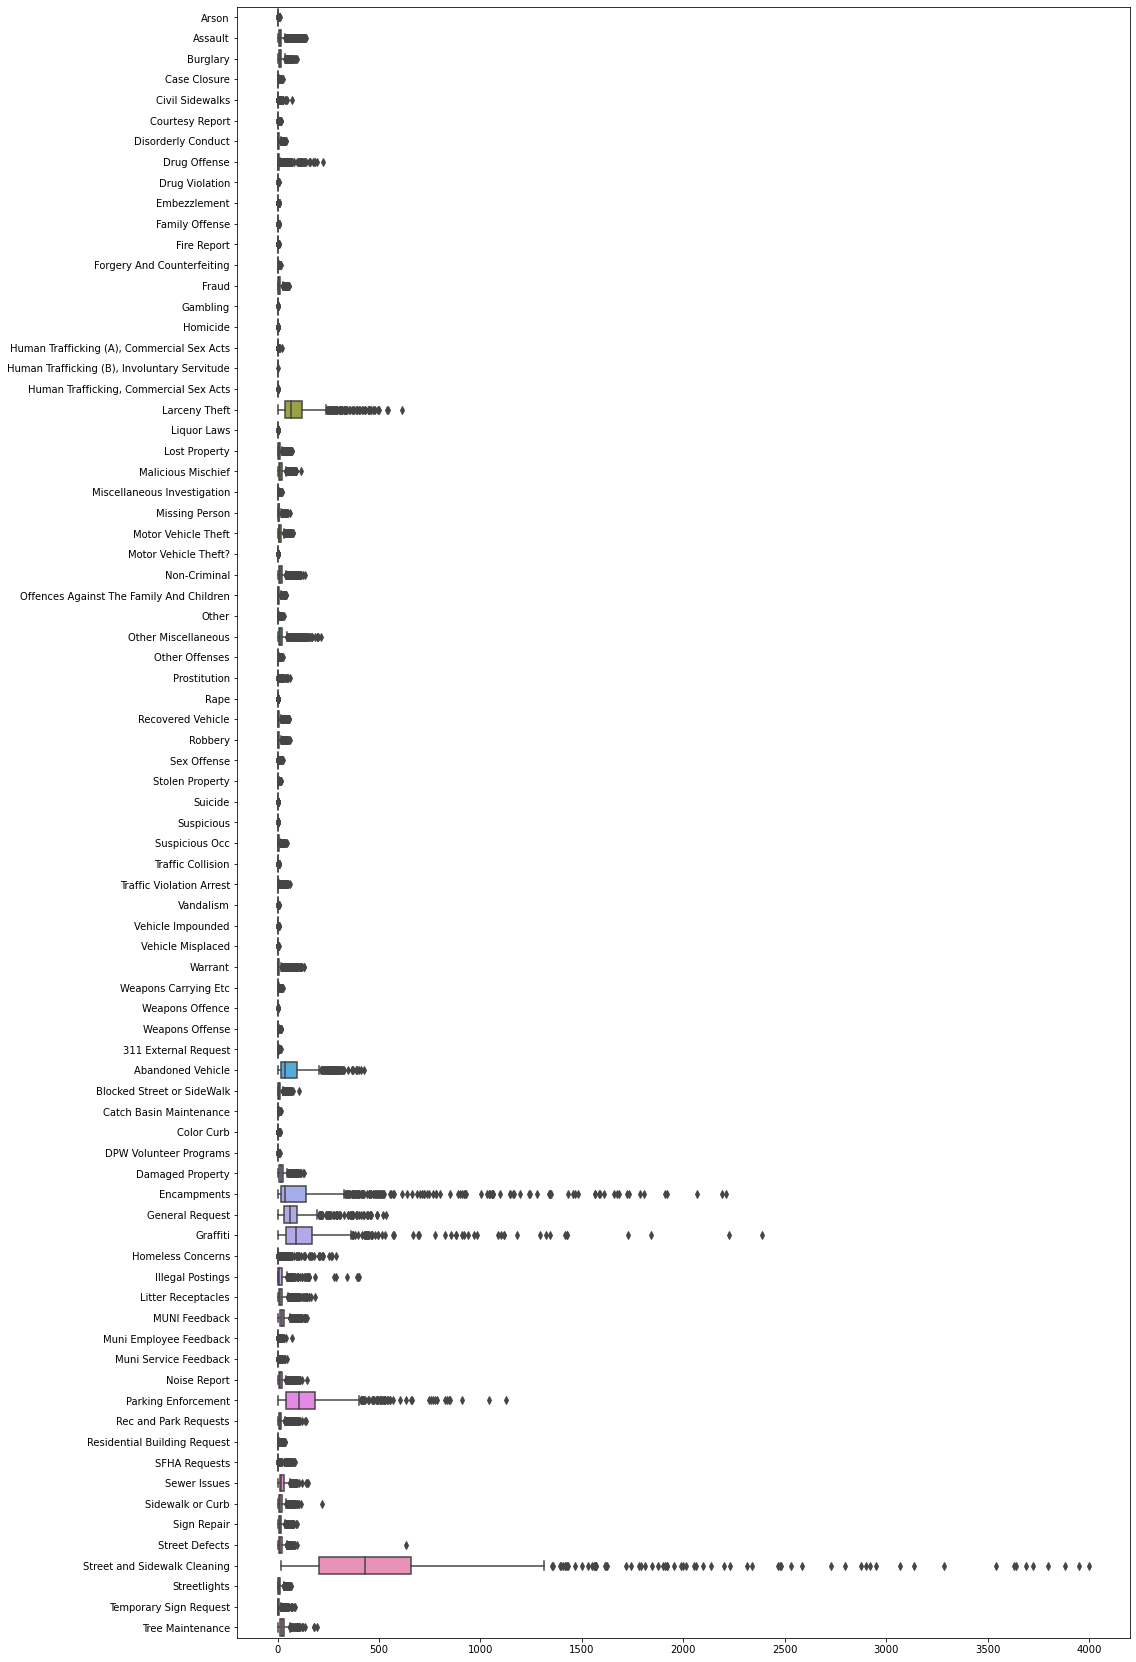

In [11]:
# Plot the features of X_train
f, ax = plt.subplots(figsize=(16,30))
g = sns.boxplot(data=X_train, orient='h')

In [12]:
df_wo_outliers = df.drop(columns=['Street and Sidewalk Cleaning','Graffiti','Encampments'])

Again, we will split out 85% of the data into the training set, leaving 15% of the data in the test set.

In [13]:
# We will split the data with 28 months in train and 5 months in test, approx 85/15 train/test split
train_wo_outliers = df_wo_outliers[df_wo_outliers['Year Month'] < 202005]
test_wo_outliers = df_wo_outliers[df_wo_outliers['Year Month'] >= 202005]

In [14]:
train_wo_outliers.shape, test_wo_outliers.shape

((1008, 79), (180, 79))

We will set X to be all the features, and y to be the Median Sale Prince __in thousands of $__.

In [15]:
X_train_wo_outliers = train_wo_outliers.drop(columns='Median Sale Price')
X_test_wo_outliers = test_wo_outliers.drop(columns='Median Sale Price')
y_train_wo_outliers = train_wo_outliers['Median Sale Price'] / 1000
y_test_wo_outliers = test_wo_outliers['Median Sale Price'] / 1000

In [16]:
X_train_wo_outliers.shape, X_test_wo_outliers.shape

((1008, 78), (180, 78))

In [17]:
y_train_wo_outliers.shape, y_test_wo_outliers.shape

((1008,), (180,))

In [18]:
# Save the 'Year Month' and 'Neighborhood' columns from the train/test data into ids_train and ids_test
# and drop these from 'X_train' and 'X_test'
ids_list = ['Year Month', 'Neighborhood']
ids_train_wo_outliers = X_train_wo_outliers[ids_list]
ids_test_wo_outliers = X_test_wo_outliers[ids_list]
X_train_wo_outliers.drop(columns=ids_list, inplace=True)
X_test_wo_outliers.drop(columns=ids_list, inplace=True)
X_train_wo_outliers.shape, X_test_wo_outliers.shape

((1008, 76), (180, 76))

## 6 Models<a id='6_Models'></a>

We're ready to create and evaluate some models. In order to do this, for each model, we will create a pipeline, then pass it into `GridSearchCV` to determine our optimal parameters for that model.

Each pipeline will consist of:
  * scaler: since our features contain numbers that vary by orders of magniture, we must scale them in preparation for PCA
  * dimensionality reducer (i.e. PCA, SelectKBest) : reduce dimensionality of the data or selectively choose features
  * regressor: our prediction component
  
We will use the default `GridSearchCV` scoring mechanism, which, for regression, is `r2_score`.

We will also run the models against 

In [19]:
# define a model evaluation method: pass in a list of models, a descriptor, 
def print_model_evaluation(models, descriptor, starting_model_num=1, X_test_set=X_test, y_test_set=y_test):
    print(' '*(len(descriptor)+1) + "          R2(train)  R2(test)   MAE          SQRT(MSE)")
    for i, model in enumerate(models, start=starting_model_num):
        y_pred = model.best_estimator_.predict(X_test_set)
        print("{} Model {}:  {:0.6f}   {:0.6f}   {:0,.6f}   {:0,.6f}".format(
            descriptor,
            i, 
            model.best_score_, 
            r2_score(y_test_set, y_pred), 
            mean_absolute_error(y_test_set, y_pred), 
            (mean_squared_error(y_test_set, y_pred))**0.5))

### 6.0 Dummy Model 0 - Standard Scaler, PCA, DummyRegressor<a id='6.0_Model_0_-_StandardScaler_PCA_DummyRegressor'></a>

Let's find a baseline with a `DummyRegressor`. In our previous notebook `3-Preprocessing_and_Training.ipynb`, we determined that when PCA n_components=4, 91.5% of the variance is already explained.

In [20]:
pipe_0 = make_pipeline(
    StandardScaler(), 
    PCA(n_components=4, random_state=42),
    DummyRegressor() )
pipe_0.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'dummyregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'dummyregressor__constant', 'dummyregressor__quantile', 'dummyregressor__strategy'])

In [21]:
param_grid_0 = {'dummyregressor__strategy': ['mean','median']}
model_0 = GridSearchCV(pipe_0, param_grid_0, cv=5)
model_0.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=4, random_state=42)),
                                       ('dummyregressor', DummyRegressor())]),
             param_grid={'dummyregressor__strategy': ['mean', 'median']})

In [22]:
print("Model 0: Best Score: " + str(model_0.best_score_))
print("Model 0: Best Parameters: " + str(model_0.best_params_))

Model 0: Best Score: -0.0014654209162468846
Model 0: Best Parameters: {'dummyregressor__strategy': 'mean'}


In [23]:
print_model_evaluation([model_0], 'Dummy', 0)

                R2(train)  R2(test)   MAE          SQRT(MSE)
Dummy Model 0:  -0.001465   -0.000054   366.071097   453.689118


### 6.1 Linear Regression Models<a id='6.1_Linear_Regression_Models'></a>

We will first compare different pipelines that use `LinearRegression`.

#### 6.1.1 Model 1 - Standard Scaler, PCA, Linear Regression<a id='6.1.1_Model_1_-_StandardScaler_PCA_LinearRegression'></a>

Our first model uses a basic pipeline consisting of `StandardScaler`, `PCA`, and `LinearRegression`.

In [24]:
pipe_1 = make_pipeline(
    StandardScaler(), 
    PCA(random_state=42),
    LinearRegression() )
pipe_1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [25]:
param_grid_1 = {'pca__n_components': np.arange(4,20)}
model_1 = GridSearchCV(pipe_1, param_grid_1, cv=5)
model_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [26]:
print("Model 1: Best Score: " + str(model_1.best_score_))
print("Model 1: Best Parameters: " + str(model_1.best_params_))

Model 1: Best Score: 0.2376077027842245
Model 1: Best Parameters: {'pca__n_components': 17}


#### 6.1.2 Model 2 - Robust Scaler, PCA, Linear Regression<a id='6.1.2_Model_2_-_RobustScaler_PCA_LinearRegression'></a>

Our second model will try to improve on the first by switching out the `StandardScaler` for the `RobustScaler`.

In [27]:
pipe_2 = make_pipeline(
    RobustScaler(), 
    PCA(random_state=42),
    LinearRegression() )
pipe_2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'pca', 'linearregression', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [28]:
param_grid_2 = {'pca__n_components': np.arange(4,20)}
model_2 = GridSearchCV(pipe_2, param_grid_2, cv=5)
model_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [29]:
print("Model 2: Best Score: " + str(model_2.best_score_))
print("Model 2: Best Parameters: " + str(model_2.best_params_))

Model 2: Best Score: 0.26785265231223887
Model 2: Best Parameters: {'pca__n_components': 17}


#### 6.1.3 Model 3 - Min Max Scaler, PCA, Linear Regression<a id='6.1.3_Model_3_-_MinMaxScaler_PCA_LinearRegression'></a>

Our third model will try to improve on the second by switching out the `RobustScaler` for the `MinMaxScaler`.

In [30]:
pipe_3 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    LinearRegression() )
pipe_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'linearregression', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [31]:
param_grid_3 = {'pca__n_components': np.arange(4,20)}
model_3 = GridSearchCV(pipe_3, param_grid_3, cv=5)
model_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [32]:
print("Model 3: Best Score: " + str(model_3.best_score_))
print("Model 3: Best Parameters: " + str(model_3.best_params_))

Model 3: Best Score: 0.28029558743141003
Model 3: Best Parameters: {'pca__n_components': 19}


#### 6.1.4 Linear Regression Model Evaluation<a id='6.1.4_Linear_Regression_Model_Evaluation'></a>

Let's evaluate the above models, comparing the different scalers.

In [33]:
lin_reg_models = [model_1, model_2, model_3]
print_model_evaluation(lin_reg_models, 'Linear Regression', 1)

                            R2(train)  R2(test)   MAE          SQRT(MSE)
Linear Regression Model 1:  0.237608   0.273431   291.680729   386.709726
Linear Regression Model 2:  0.267853   0.239206   298.509300   395.712791
Linear Regression Model 3:  0.280296   0.290939   282.675887   382.022059


It appears that `model_3`, which uses `MinMaxScaler`, produces the best results. However, none of these model evaluation metrics look particularly good. Let's try using these same models on the data without outliers to see if that produces better results.

#### 6.1.5 Linear Regression Models - Data Without Outliers<a id='6.1.5_Linear_Regression_Models-Data_Without_Outliers'></a>

Let's run the above models, but on the data without outliers.

In [34]:
model_1.fit(X_train_wo_outliers, y_train_wo_outliers)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [35]:
print("Model 1 - Without Outliers: Best Score: " + str(model_1.best_score_))
print("Model 1 - Without Outliers: Best Parameters: " + str(model_1.best_params_))

Model 1 - Without Outliers: Best Score: 0.2255374236724082
Model 1 - Without Outliers: Best Parameters: {'pca__n_components': 18}


In [36]:
model_2.fit(X_train_wo_outliers, y_train_wo_outliers)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [37]:
print("Model 2 - Without Outliers: Best Score: " + str(model_2.best_score_))
print("Model 2 - Without Outliers: Best Parameters: " + str(model_2.best_params_))

Model 2 - Without Outliers: Best Score: 0.2612535139441946
Model 2 - Without Outliers: Best Parameters: {'pca__n_components': 18}


In [38]:
model_3.fit(X_train_wo_outliers, y_train_wo_outliers)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [39]:
print("Model 3 - Without Outliers: Best Score: " + str(model_3.best_score_))
print("Model 3 - Without Outliers: Best Parameters: " + str(model_3.best_params_))

Model 3 - Without Outliers: Best Score: 0.27811481323757625
Model 3 - Without Outliers: Best Parameters: {'pca__n_components': 19}


#### 6.1.6 Linear Regression Model Evaluation - Without Outliers<a id='6.1.6_Linear_Regression_Model_Evaluation-Without_Outliers'></a>

Let's evaluate the above models running on data without outliers.

In [40]:
print_model_evaluation(lin_reg_models, 'Linear Regression - Without Outliers', 1, X_test_wo_outliers, y_test_wo_outliers)

                                               R2(train)  R2(test)   MAE          SQRT(MSE)
Linear Regression - Without Outliers Model 1:  0.225537   0.275221   291.069177   386.233093
Linear Regression - Without Outliers Model 2:  0.261254   0.276444   283.060429   385.907194
Linear Regression - Without Outliers Model 3:  0.278115   0.240599   304.171410   395.350381


Again, it appears that `model_3` produces the best results. However, it doesn't appear that training on data without outliers produces any better results than using the complete data set. Thus, we will continue to use the complete data set going forward.

### 6.2 Other Regression Models<a id='6.2_Other_Regression_Models'></a>

We will try some other regression models.

#### 6.2.1 Model 4 - Min Max Scaler, PCA, Random Forest<a id='6.2.1_Model_4_-_MinMaxScaler_PCA_RandomForest'></a>

In the above models, we seem to have determined that the best scaler to use is `MinMaxScaler` and the best number of components for PCA is anywhere from 17 to 20. In the fourth model, we will swap out the `LinearRegressor` for `RandomForestRegressor`.

In [41]:
pipe_4 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    RandomForestRegressor(random_state=42) )
pipe_4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'randomforestregressor', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [42]:
param_grid_4 = {'pca__n_components': np.arange(17,20),
                'randomforestregressor__n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
                'randomforestregressor__max_depth': [2, 5, 10, 20]}
model_4 = GridSearchCV(pipe_4, param_grid_4, cv=5, n_jobs=-1)
model_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': array([17, 18, 19]),
                         'randomforestregressor__max_depth': [2, 5, 10, 20],
                         'randomforestregressor__n_estimators': [10, 31, 100,
                                                                 316, 1000]})

In [43]:
print("Model 4: Best Score: " + str(model_4.best_score_))
print("Model 4: Best Parameters: " + str(model_4.best_params_))

Model 4: Best Score: 0.4405929585230606
Model 4: Best Parameters: {'pca__n_components': 19, 'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 316}


#### 6.2.2 Model 5 - Min Max Scaler, PCA, Ridge<a id='6.2.2_Model_5_-_MinMaxScaler_PCA_Ridge'></a>

Here we will try the `Ridge` regressor. We will increase the hyperparameter tuning for PCA since Ridge does better with more features.

In [44]:
pipe_5 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    Ridge() )
pipe_5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'ridge', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [45]:
param_grid_5 = {'pca__n_components': np.arange(4,80,4),
                'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 300, 500, 1000]}
model_5 = GridSearchCV(pipe_5, param_grid_5, cv=5, n_jobs=-1)
model_5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'pca__n_components': array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68,
       72, 76]),
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 300,
                                          500, 1000]})

In [46]:
print("Model 5: Best Score: " + str(model_5.best_score_))
print("Model 5: Best Parameters: " + str(model_5.best_params_))

Model 5: Best Score: 0.3136843278835835
Model 5: Best Parameters: {'pca__n_components': 76, 'ridge__alpha': 1}


#### 6.2.3 Model 6 - Min Max Scaler, PCA, Lasso<a id='6.2.3_Model_6_-_MinMaxScaler_PCA_Lasso'></a>

Let's swap out `Ridge` for `Lasso`.

In [47]:
pipe_6 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    Lasso() )
pipe_6.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'lasso', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [48]:
param_grid_6 = {'pca__n_components': np.arange(20,80,4),
                'lasso__alpha': [0.1, 0.25, 0.5, 1, 5, 10]}
model_6 = GridSearchCV(pipe_6, param_grid_6, cv=5, n_jobs=-1)
model_6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.1, 0.25, 0.5, 1, 5, 10],
                         'pca__n_components': array([20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76])})

In [49]:
print("Model 6: Best Score: " + str(model_6.best_score_))
print("Model 6: Best Parameters: " + str(model_6.best_params_))

Model 6: Best Score: 0.308941336302304
Model 6: Best Parameters: {'lasso__alpha': 0.5, 'pca__n_components': 76}


In [31]:
print("Model 6: Best Score: " + str(model_6.best_score_))
print("Model 6: Best Parameters: " + str(model_6.best_params_))

Model 6: Best Score: 0.32941407138721235
Model 6: Best Parameters: {'lasso__alpha': 5, 'pca__n_components': 76}


#### 6.2.4 Model 7 - Min Max Scaler, PCA, LassoLars<a id='6.2.4_Model_7_-_MinMaxScaler_PCA_LassoLars'></a>

Let's swap out `Lasso` for `LassoLars`.

In [50]:
pipe_7 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    LassoLars() )
pipe_7.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'lassolars', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'lassolars__alpha', 'lassolars__copy_X', 'lassolars__eps', 'lassolars__fit_intercept', 'lassolars__fit_path', 'lassolars__jitter', 'lassolars__max_iter', 'lassolars__normalize', 'lassolars__positive', 'lassolars__precompute', 'lassolars__random_state', 'lassolars__verbose'])

In [51]:
param_grid_7 = {'pca__n_components': np.arange(20,80,4),
                'lassolars__alpha': [0.1, 0.15, 0.25, 0.3, 0.5, 0.9]}
model_7 = GridSearchCV(pipe_7, param_grid_7, cv=5, n_jobs=-1)
model_7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('lassolars', LassoLars())]),
             n_jobs=-1,
             param_grid={'lassolars__alpha': [0.1, 0.15, 0.25, 0.3, 0.5, 0.9],
                         'pca__n_components': array([20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76])})

In [52]:
print("Model 7: Best Score: " + str(model_7.best_score_))
print("Model 7: Best Parameters: " + str(model_7.best_params_))

Model 7: Best Score: 0.316116888951176
Model 7: Best Parameters: {'lassolars__alpha': 0.3, 'pca__n_components': 76}


#### 6.2.5 Model 8 - Min Max Scaler, PCA, ElasticNet<a id='6.2.5_Model_8_-_MinMaxScaler_PCA_ElasticNet'></a>

Let's try `ElasticNet`, should help with sparsity of data.

In [53]:
pipe_8 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    ElasticNet() )
pipe_8.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'elasticnet', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'elasticnet__alpha', 'elasticnet__copy_X', 'elasticnet__fit_intercept', 'elasticnet__l1_ratio', 'elasticnet__max_iter', 'elasticnet__normalize', 'elasticnet__positive', 'elasticnet__precompute', 'elasticnet__random_state', 'elasticnet__selection', 'elasticnet__tol', 'elasticnet__warm_start'])

In [54]:
param_grid_8 = {'pca__n_components': np.arange(20,80,4),
                'elasticnet__alpha': [0.1, 0.15, 0.25, 0.3, 0.5, 0.9],
                'elasticnet__l1_ratio': [0.05, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99] }
model_8 = GridSearchCV(pipe_8, param_grid_8, cv=5, n_jobs=-1)
model_8.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.1, 0.15, 0.25, 0.3, 0.5, 0.9],
                         'elasticnet__l1_ratio': [0.05, 0.1, 0.5, 0.7, 0.9,
                                                  0.95, 0.99],
                         'pca__n_components': array([20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76])})

In [55]:
print("Model 8: Best Score: " + str(model_8.best_score_))
print("Model 8: Best Parameters: " + str(model_8.best_params_))

Model 8: Best Score: 0.3135745823982837
Model 8: Best Parameters: {'elasticnet__alpha': 0.15, 'elasticnet__l1_ratio': 0.99, 'pca__n_components': 76}


#### 6.2.6 Other Regression Model Evaluation<a id='6.2.6_Other_Regression_Model_Evaluation'></a>

Let's evaluate the above models.

In [56]:
other_reg_models = [model_4, model_5, model_6, model_7, model_8]
print_model_evaluation(other_reg_models, 'Other Regression', 4)

                           R2(train)  R2(test)   MAE          SQRT(MSE)
Other Regression Model 4:  0.440593   0.336740   252.539446   369.478008
Other Regression Model 5:  0.313684   0.298093   282.591042   380.090046
Other Regression Model 6:  0.308941   0.265844   287.848421   388.723602
Other Regression Model 7:  0.316117   0.242684   289.978142   394.807398
Other Regression Model 8:  0.313575   0.335849   278.552623   369.726007


Of these models, it appears that `model_4`, which uses `RandomForestRegressor` produces the best results. 

### 6.3 Experimental Models<a id='6.3_Experimental_Models'></a>

We'll try a few more models, some based on earlier models.

#### 6.3.1 Model 9 - Min Max Scaler, SelectKBest, Linear Regression<a id='6.3.1_Model_9_-_MinMaxScaler_SelectKBest_LinearRegression'></a>

Instead of using `PCA`, we will try using `SelectKBest` feature selection.

In [57]:
pipe_9 = make_pipeline(
    MinMaxScaler(), 
    SelectKBest(mutual_info_regression),
    LinearRegression() )
pipe_9.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'selectkbest', 'linearregression', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [58]:
param_grid_9 = {'selectkbest__k': np.arange(30,60) }
model_9 = GridSearchCV(pipe_9, param_grid_9, cv=5)
model_9.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x000002CAF506ED30>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])})

In [59]:
print("Model 9: Best Score: " + str(model_9.best_score_))
print("Model 9: Best Parameters: " + str(model_9.best_params_))

Model 9: Best Score: 0.32471466703054946
Model 9: Best Parameters: {'selectkbest__k': 48}


#### 6.3.2 Model 10 - Min Max Scaler, Limited PCA, Random Forest<a id='6.3.2_Model_10_-_MinMaxScaler_LimitedPCA_RandomForest'></a>

In the above models, we seem to have determined that the best number of components for PCA is greater than 15. In this model, we will take our most successful fourth model, and limit the number of PCA components we check to see if we can get better results.

In [60]:
pipe_10 = make_pipeline(
    MinMaxScaler(), 
    PCA(random_state=42),
    RandomForestRegressor(random_state=42) )
pipe_10.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'pca', 'randomforestregressor', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [61]:
param_grid_10 = {'pca__n_components': np.arange(1,10),
                'randomforestregressor__n_estimators': [int(n) for n in np.logspace(start=1, stop=2, num=5)],
                'randomforestregressor__max_depth': [2, 5, 10, 20]}
model_10 = GridSearchCV(pipe_10, param_grid_10, cv=5, n_jobs=-1)
model_10.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'randomforestregressor__max_depth': [2, 5, 10, 20],
                         'randomforestregressor__n_estimators': [10, 17, 31, 56,
                                                                 100]})

In [62]:
print("Model 10: Best Score: " + str(model_10.best_score_))
print("Model 10: Best Parameters: " + str(model_10.best_params_))

Model 10: Best Score: 0.4444496552572458
Model 10: Best Parameters: {'pca__n_components': 7, 'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 31}


#### 6.3.3 Experimental Model Evaluation<a id='6.3.3_Experimental_Model_Evaluation'></a>

Let's evaluate the above models.

In [64]:
experimental_models = [model_9, model_10]
print_model_evaluation(experimental_models, 'Experimental', 9)

                       R2(train)  R2(test)   MAE          SQRT(MSE)
Experimental Model 9:  0.324715   0.046348   305.201684   443.038591
Experimental Model 10:  0.444450   0.349708   247.694773   365.848023


In [65]:
print_model_evaluation([model_4], 'Random Forest', 4)

                        R2(train)  R2(test)   MAE          SQRT(MSE)
Random Forest Model 4:  0.440593   0.336740   252.539446   369.478008


Our original Random Forest `model_4` and the limited PCA Random Forest `model_10` perform quite similarly. Note that the number of PCA components selected for `model_10` was 7, which explains 95.5% of the variance of the features; compare this to our original `model_4` which used 19 PCA components (explains 98.3% of the variance).

One interesting thing to note is that although `SelectKBest` performed fine on the training set, it performed extremely poorly on the test set, which implies that this feature selection overfitted on the data.

## 7 Conclusion<a id='7_Conclusion'></a>

Even though we can determine from running our different model evaluations that using `MinMaxScaler`, `PCA`, and `RandomForestRegressor` provide the best model, that model is still not very good at predicting San Francisco housing prices. Why is this? Some different theories:

  1. __Are outliers disrupting the model?__ It's possible, and the effectiveness of `MinMaxScaler`, which boxes the range of the features in, shows that the features' large range has an effect on the modeling. However, we did try removing "outliers", i.e. features that have the greatest range and most disrupt the distribution, and there was negligible effect on model performance.
  
  2. __Is this the curse of dimensionality?__ We might have too many features and not enough data. However, if this were the main detractor of model performance, we might have seen a greater improvement when we limited the number of PCA components used, and we did not see that.
  
  3. __Do police incident reports and 311 cases actually influence housing prices?__ Our initial hypothesis was that we could develop a model to predict housing prices in San Francisco based on police incident reports and 311 cases. Perhaps this is not the case and our initial hypothesis is invalid. Could neighborhoods actually be homogeneous? We will explore this in another notebook.